## **Setup**

In [ ]:
!pip install -q transformers
!pip install -q bitsandbytes
!pip install -q peft
!pip install -q torch
!pip install -q accelerate -U

In [ ]:
from transformers import TextDataset, DataCollatorForLanguageModeling
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from transformers import Trainer, TrainingArguments

import os
import torch
import torch.nn as nn
import bitsandbytes as bnb
import transformers
import peft

In [ ]:
model = GPT2LMHeadModel.from_pretrained('gpt2')

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

## **LoRA Setup**

In [ ]:
# We freeze the models weights by setting the requires_grad attribute to False.

for param in model.parameters():
  param.requires_grad = False
  if param.ndim == 1:
    param.data = param.data.to(torch.float32)

model.gradient_checkpointing_enable()
model.enable_input_require_grads()

class CastOutputToFloat(nn.Sequential):
  def forward(self, x): return super().forward(x).to(torch.float32)
model.lm_head = CastOutputToFloat(model.lm_head)

In [ ]:
# Prints the number of trainable parameters in the model.

def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [ ]:
# Setup LoRA Config using peft

from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 589824 || all params: 125029632 || trainable%: 0.4717473694555863


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/model.py:311: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


## **Data Loading and Tokenization**

In [ ]:
data = []

with open("parsed_quotes_context.txt") as sherlock_quotes_file:
    lines = sherlock_quotes_file.readlines()
    for i in range(0, len(lines), 3):
        if i + 1 < len(lines):
            line = f"{lines[i+1].strip()}"
            data.append(line)

In [ ]:
len(data)

855

In [ ]:
tokenizer.pad_token = tokenizer.eos_token

In [ ]:
from sklearn.model_selection import train_test_split
train_data, val_data = train_test_split(data, test_size=0.2, random_state=50)

train_data = [tokenizer(line) for line in train_data]
val_data = [tokenizer(line) for line in val_data]

In [ ]:
# To instead load a pretrained model:

# model = GPT2LMHeadModel.from_pretrained("gpt2-sherlock-v0")

## **Training**

In [ ]:
seed = 42
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

trainer = transformers.Trainer(
    model=model,
    train_dataset=train_data,
    eval_dataset=val_data,
    args=transformers.TrainingArguments(
        per_device_train_batch_size=4,
        gradient_accumulation_steps=4,
        warmup_steps=100,
        max_steps=1000,
        learning_rate=2e-4,
        fp16=True,
        logging_steps=1,
        evaluation_strategy="steps",
        eval_steps=20,
        output_dir='outputs',
        save_steps=250,
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
)
model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
20,4.408100,4.062870
40,4.264100,4.023294
60,3.825500,3.926784
80,4.011100,3.829361
100,3.818200,3.769075
120,3.569500,3.724793
140,3.956000,3.694839
160,4.079700,3.679628
180,3.988700,3.668976
200,3.606500,3.660871


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.

TrainOutput(global_step=1000, training_loss=3.6797610895633697, metrics={'train_runtime': 408.776, 'train_samples_per_second': 39.141, 'train_steps_per_second': 2.446, 'total_flos': 413601498427392.0, 'train_loss': 3.6797610895633697, 'epoch': 23.39})

## **Sampling**

In [ ]:
from transformers import set_seed

set_seed(40)

device = model.device
batch = tokenizer("How would you find who committed the crime, Detective? ", return_tensors='pt')
batch.to(device)

sample_outputs = model.generate(
    **batch,
    max_new_tokens=100,
    do_sample=True,
    top_k=50,
    top_p=0.95,
    num_return_sequences=1,
)

print("Output:\n" + 100 * '-')
for i, sample_output in enumerate(sample_outputs):
  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1473: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Output:
----------------------------------------------------------------------------------------------------
0: How would you find who committed the crime, Detective?  You should have come to that house, Watson. It would have been a nice escape, if you'd come with me. We should have an appointment, or a report from the witness bench. It might be better to stay for a few minutes. We may be able to work it out in a few hours. Please, please; there's a very old lady here. There's a young man on the edge of the bed, who's about to commit some serious foul here in our room


In [ ]:
# To save the model

# model.save_pretrained("gpt2-sherlock-v0", from_pt=True)

## **Graphs and Visualizations**

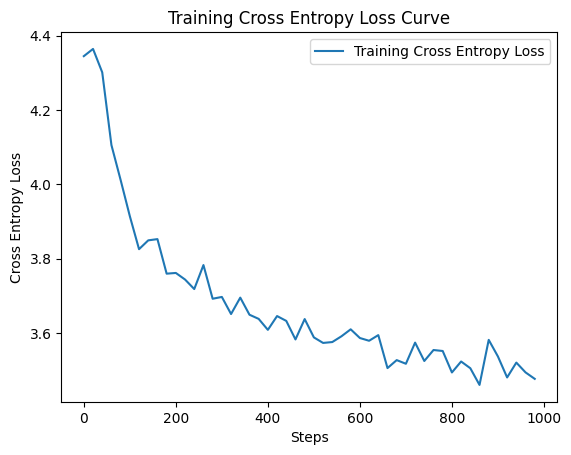

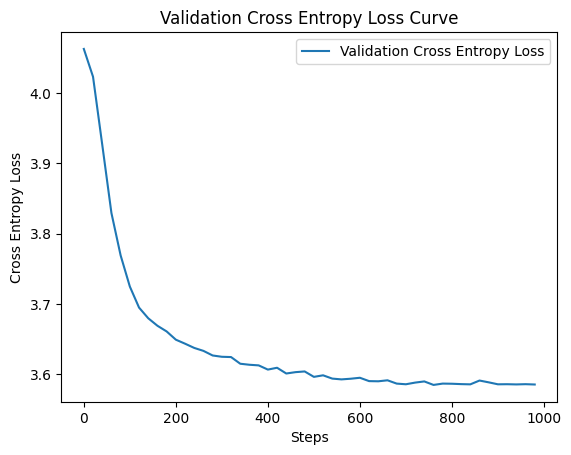

In [ ]:
import matplotlib.pyplot as plt

train_loss_values = []
val_loss_values = []

# Access the training and val loss values from the Trainer's log
for i, x in enumerate(trainer.state.log_history[:-1]):
  if (i+1) % 21 == 0:
    val_loss_values.append(x["eval_loss"])
  else:
    train_loss_values.append(x["loss"])
train_loss_values = [sum(train_loss_values[i:i+20]) / 20 for i in range(0, len(train_loss_values), 20)]

# Plot the training loss curve
plt.plot(train_loss_values, label="Training Cross Entropy Loss")
plt.xlabel("Steps")
plt.xticks([0, 10, 20, 30, 40, 50], [0, 200, 400, 600, 800, 1000])
plt.ylabel("Cross Entropy Loss")
plt.title("Training Cross Entropy Loss Curve")
plt.legend()
plt.show()

# Plot the val loss curve
plt.plot(val_loss_values, label="Validation Cross Entropy Loss")
plt.xlabel("Steps")
plt.xticks([0, 10, 20, 30, 40, 50], [0, 200, 400, 600, 800, 1000])
plt.ylabel("Cross Entropy Loss")
plt.title("Validation Cross Entropy Loss Curve")
plt.legend()
plt.show()

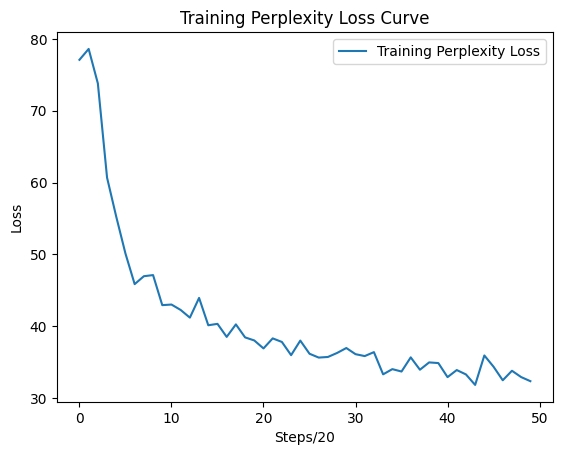

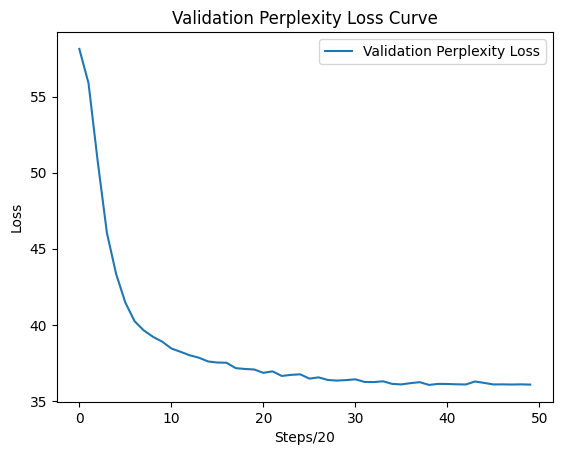

In [ ]:
import numpy as np
perplexity_train_loss_values = [np.exp(x) for x in train_loss_values]
perplexity_val_loss_values = [np.exp(x) for x in val_loss_values]

# Plot the training loss curve
plt.plot(perplexity_train_loss_values, label="Training Perplexity Loss")
plt.xlabel("Steps/20")
plt.ylabel("Loss")
plt.title("Training Perplexity Loss Curve")
plt.legend()
plt.show()

# Plot the validation loss curve
plt.plot(perplexity_val_loss_values, label="Validation Perplexity Loss")
plt.xlabel("Steps/20")
plt.ylabel("Loss")
plt.title("Validation Perplexity Loss Curve")
plt.legend()
plt.show()

## **Checkpointed Sampling**

In [ ]:
model_250 = GPT2LMHeadModel.from_pretrained("outputs/checkpoint-250")

set_seed(40)

device = model_250.device
batch = tokenizer("How can we find who robbed the house, Sherlock? ", return_tensors='pt')
batch.to(device)

sample_outputs = model_250.generate(
    **batch,
    max_new_tokens=200,
    do_sample=True,
    top_k=50,
    top_p=0.95,
    num_return_sequences=1,
)

print("Output:\n" + 100 * '-')
for i, sample_output in enumerate(sample_outputs):
  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Output:
----------------------------------------------------------------------------------------------------
0: How can we find who robbed the house, Sherlock? -------------------------- What do you mean, Watson? --------------- The man's his own friend, I suppose. He is quite right. As far as he is concerned I suppose the house will be cleared within ten minutes. But I am sure this man is a very fine gentlemen. He is very well-known to the public. He was a famous gentleman, and we have no doubt he has an ulterior motive. I don't think it's a matter of a little intrigue, since we can't quite separate his wife, Rose, from our husband, Mrs. Bess, whom I know to be very concerned about. If we can get Mrs. Bess to come to the rescue and help us we'll be sure to find him. He probably already is a very wealthy man, and perhaps the reason he's coming to my hotel and not our one is because he is trying to escape. We cannot let him get away here and then hide in the shadows. But I must say that

In [ ]:
model_500 = GPT2LMHeadModel.from_pretrained("outputs/checkpoint-500")

set_seed(40)

device = model_500.device
batch = tokenizer("How can we find who robbed the house, Sherlock? ", return_tensors='pt')
batch.to(device)

sample_outputs = model_500.generate(
    **batch,
    max_new_tokens=200,
    do_sample=True,
    top_k=50,
    top_p=0.95,
    num_return_sequences=1,
)

print("Output:\n" + 100 * '-')
for i, sample_output in enumerate(sample_outputs):
  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Output:
----------------------------------------------------------------------------------------------------
0: How can we find who robbed the house, Sherlock? -------------------------- What do you mean, Watson? --------------- The man who murdered the family at the cottage. He is an Indian. -- Yes! He's a stranger. --------------- You can't accuse him of stealing the memento Moriarty, Watson. No, no, no, no, no, you can't accuse him of stealing Moriarty. You can't. You can't. You can't. But then you won't accuse him of taking the memento Moriarty from his wife. What you've got is a new case. And it's not a new one. And it's the one that got you here. And if that murder can be described as a crime against the common man, a crime against the State, you can take the place of the old case. And this one that's got you here will be of service to the country for the rest of your lives. Well, here's your chance. Well, now--well, here's my


In [ ]:
model_750 = GPT2LMHeadModel.from_pretrained("outputs/checkpoint-750")

set_seed(40)

device = model_750.device
batch = tokenizer("How can we find who robbed the house, Sherlock? ", return_tensors='pt')
batch.to(device)

sample_outputs = model_750.generate(
    **batch,
    max_new_tokens=200,
    do_sample=True,
    top_k=50,
    top_p=0.95,
    num_return_sequences=1,
)

print("Output:\n" + 100 * '-')
for i, sample_output in enumerate(sample_outputs):
  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Output:
----------------------------------------------------------------------------------------------------
0: How can we find who robbed the house, Sherlock? -------------------------- What do you mean, Watson? What do you mean, Sherlock? What did I tell you? Do you remember I'd tell you that? Do I remember that? Well, I suppose I shall confess now and show you this picture? It's of the little woman I met at my last Christmas party, and I was thinking how wonderful it would be to have her as your dear wife. It seems to me that she must have been able to escape in the excitement and, perhaps, in her fright at the prospect of her death. To get her out of my thoughts, I must be going to work. If she can come and fetch my wife tomorrow for a second Christmas and then let her run away, I shall be glad to do it. But to make my wife's life so, I shall make her my personal companion for life. As for the picture, it will help to keep her in our minds as well as any of my other works. If she c

In [ ]:
model_0 = GPT2LMHeadModel.from_pretrained("gpt2")

set_seed(40)

device = model_0.device
batch = tokenizer("How can we find who robbed the house, Sherlock? ", return_tensors='pt')
batch.to(device)

sample_outputs = model_0.generate(
    **batch,
    max_new_tokens=200,
    do_sample=True,
    top_k=50,
    top_p=0.95,
    num_return_sequences=1,
)

print("Output:\n" + 100 * '-')
for i, sample_output in enumerate(sample_outputs):
  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Output:
----------------------------------------------------------------------------------------------------
0: How can we find who robbed the house, Sherlock?  Well, I haven't had a clue.  So I just decided to ask.  Well, there's no point in asking because it's gonna be pretty hard to find out.  And with that, we get to see what happened when Mr. Holmes, when he entered his room, stole the money.  He left the money in the drawer, but he didn't have to go back to the man who took it.  So what he did was take the money out of his pocket, and leave it on the table, that is, in the box at the back of the room.  But if you took the money out of the box, what do you do?  Well, you go down and find him, and leave it on the table, and walk up to the front door, which opens at 6:45 AM.  So, what is going on here?  Well, he was very upset with Mr.
